# Plot England major cities with labels

This notebook demonstrates code for plotting England cities along with their corresponding names. Importantly, it avoids overlapping the names and bounary by manually positioning the labels outside the boundary.

## Load packages and data

In [1]:
# import mapclassify
# from google.colab import files 
import pandas
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
%pylab inline
# sys.path.append(os.path.abspath('..'))
import inequality
import libpysal 
import os
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.patches as mpatches

from adjustText import adjust_text

from matplotlib.patches import Patch
import matplotlib.lines as mlines
import geopandas

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


/home/huanfa/miniconda3/envs/sds2021/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# another way to add a scale bar of 10km
# https://geopandas.org/en/stable/gallery/matplotlib_scalebar.html
from shapely.geometry.point import Point

points = geopandas.GeoSeries([Point(-73.5, 50), Point(-74.5, 50)], crs=4326)  # Geographic WGS 84 - degrees
points = points.to_crs(32619) # Projected WGS 84 - meters

distance_meters = points[0].distance(points[1])

In [3]:
# read in uk boundary data from https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/31a5004908f749cbbce606d4c6d560b9/geoPackage?layers=0
uk_boundaries = geopandas.read_file('https://opendata.arcgis.com/datasets/31a5004908f749cbbce606d4c6d560b9_0.geojson')
# keep only CTRY21NM = ‘England’, name it as England_boundaries
england_boundaries = uk_boundaries[uk_boundaries['CTRY21NM'] == 'England']

In [4]:
gdf_city_town = geopandas.read_file('https://open-geography-portalx-ons.hub.arcgis.com/api/download/v1/items/980da620a0264647bd679642f96b42c1/geojson?layers=0')
# If the link above does not work, you can use the following line to read the data from github
# gdf_city_town = geopandas.read_file('/vsicurl/https://raw.githubusercontent.com/huanfachen/Spatial_Data_Science/main/Dataset/Major_Towns_and_Cities_December_2015_Boundaries/Major_Towns_and_Cities_December_2015_Boundaries.shp')
gdf_city_town = gdf_city_town.to_crs('epsg:4326')

In [5]:
# keep only the rows of gdf_city_town that are inside england_boundaries
gdf_city_town = geopandas.overlay(gdf_city_town,england_boundaries, how='intersection')

## Pick up a few major cities and obtain their centroids

In [6]:
# keep a few major cities: London, Birmingham, Leeds, Bristol, Manchester, Glasgow, Edingburgh, Cardiff
gdf_city_town_major = gdf_city_town[gdf_city_town.TCITY15NM.isin(["London", "Birmingham", "Leeds", "Bristol", "Manchester", "Plymouth", "Newcastle upon Tyne", "York"])]
# print(gdf_city_town_major)
gdf_city_town_major_centroid = geopandas.GeoDataFrame(gdf_city_town_major, geometry=gdf_city_town_major.geometry.centroid, crs=gdf_city_town_major.crs)
# print(gdf_city_town_major_centroid)

In [11]:
gdf_city_town_major_centroid.TCITY15NM

6               Birmingham
14                 Bristol
49                   Leeds
53                  London
56              Manchester
60     Newcastle upon Tyne
69                Plymouth
108                   York
Name: TCITY15NM, dtype: object

## Plot the map

Birmingham
Bristol
Leeds
London
Manchester
Newcastle upon Tyne
Plymouth
York


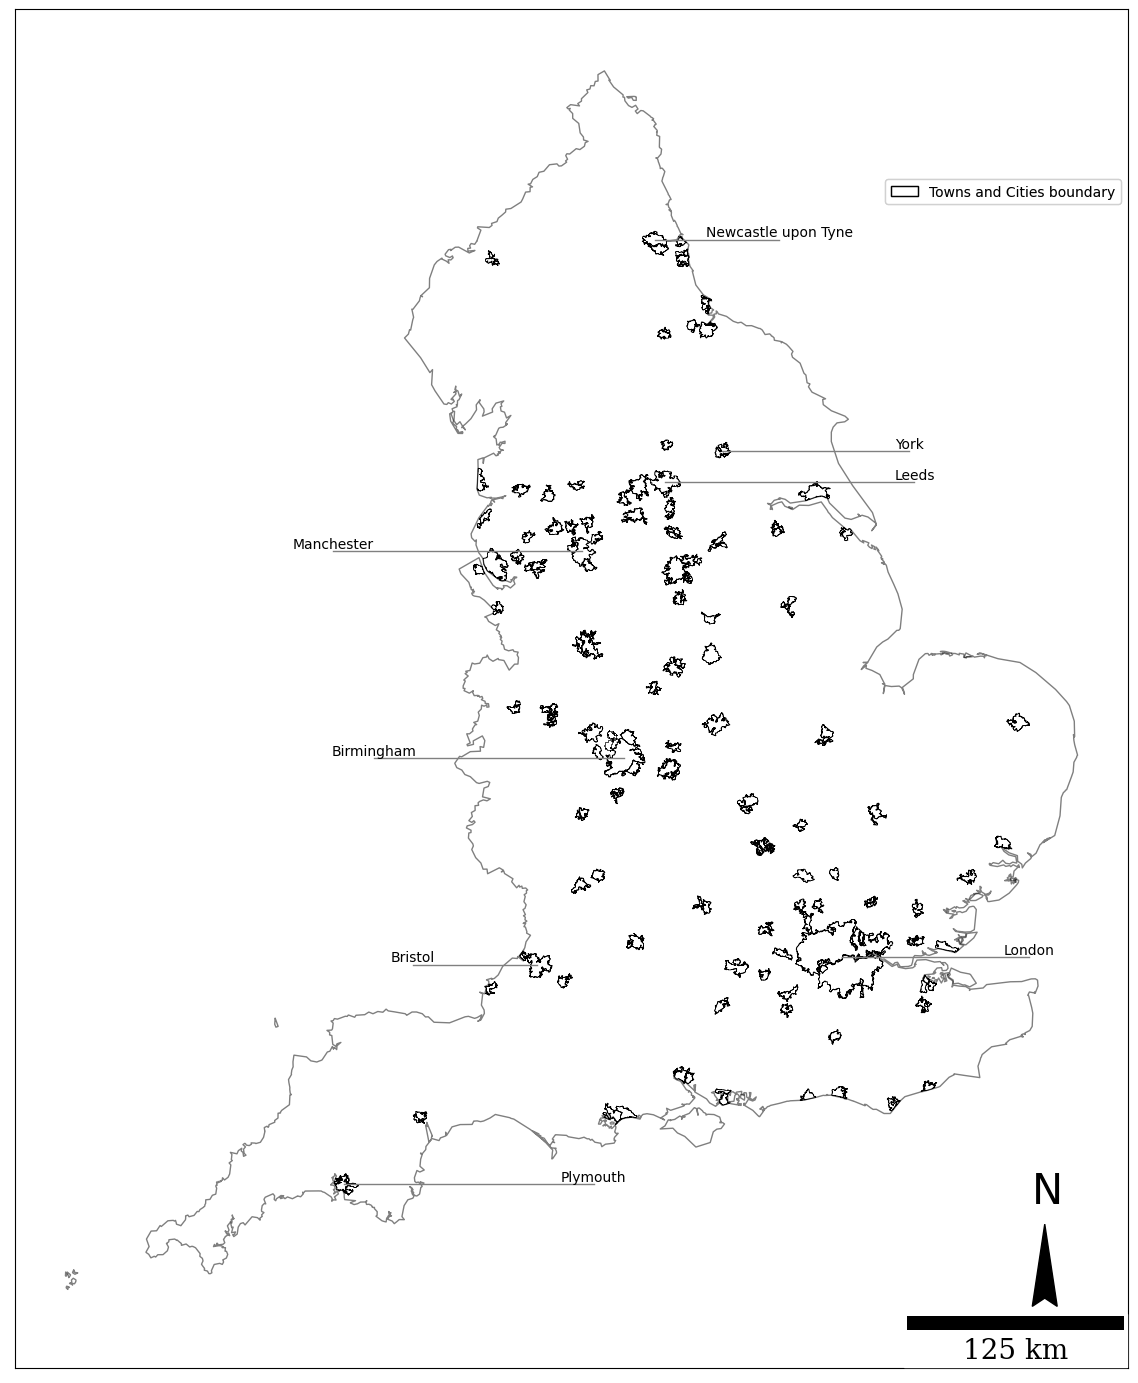

In [14]:
# the intervals of the colour bins are the quantiles of service level plus the zero value (in order to highlight the underserved areas)
fig, ax = plt.subplots(figsize=(18,18),dpi=100)
# ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])

# add legend of urban boundary
city_town_boundary = mpatches.Patch(edgecolor = 'black', facecolor='none', label='Towns and Cities boundary')
ax.add_artist(ax.legend(handles=[city_town_boundary], bbox_to_anchor=(1, 0.88), loc="upper right"))

# plot England boundary
england_boundaries.plot(edgecolor=(0, 0, 0,0.5), facecolor='none', linewidth=1,ax=ax)

# plot urban and rural boundary
gdf_city_town.plot(edgecolor='black', facecolor='none', linewidth=0.5,ax=ax)

# add labels of city centroids
# Create a dictionary of offsets for labels. This needs manual adjustment based on the plot.
# Example: label_offsets = {'London': (0.1, 0.2), 'Birmingham': (-0.1, -0.2), ...}
label_offsets = {
    'Birmingham': (-2, 0),  # Replace with actual city names and desired offsets
    'Bristol': (-1, 0),
    'Leeds': (2, 0),
    'Manchester': (-2, 0),
    'London': (1.5, 0),
    'Newcastle upon Tyne': (1, 0),
    'Plymouth': (2, 0),
    'York': (1.5, 0),
    # Add further cities and their offsets
}

# Annotate each city with its corresponding label
for idx, row in gdf_city_town_major_centroid.iterrows():
    city_name = row['TCITY15NM']
    # print(city_name)
    if city_name in label_offsets:
    
        offset = label_offsets[city_name]
        xytext = (row.geometry.x + offset[0], row.geometry.y + offset[1])

        # Plot the label for the city offset by the specified amount
        ax.text(
            xytext[0], xytext[1], city_name,
#             bbox=dict(facecolor='white', alpha=0.5),
            ha='center', va='bottom'
        )
        
        # Draw a line (bar) from the city to the label
        line = Line2D([row.geometry.x, xytext[0]], [row.geometry.y, xytext[1]], lw=1, color='grey', linestyle="-")
        ax.add_line(line)

# # Define the generate_grid_points_in_polygon function
# def generate_grid_points_in_polygon(polygon, grid_interval_x, grid_interval_y):
#     # Get the bounds of the polygon
#     minx, miny, maxx, maxy = polygon.bounds
#     grid_x_points = np.arange(minx, maxx, grid_interval_x)
#     grid_y_points = np.arange(miny, maxy, grid_interval_y)
#     # Create points from the grid and check if they are within the polygon
#     grid_points = [Point(x, y) for x in grid_x_points for y in grid_y_points if polygon.contains(Point(x, y))]
#     return grid_points

# # Specify the intervals for the grid along the x- and y-axes
# interval_x = 0.1 
# interval_y = 0.1 

# # Generate random points within the England boundary polygon
# num_random_points = 1000  # Number of points to generate
# england_polygon = gdf_MSOA_outline.geometry.iloc[0]  # Assuming only one polygon
# random_points = generate_grid_points_in_polygon(england_polygon, interval_x, interval_y)

# # add labels of major cities
# texts = [ax.text(x, y, label, ha='right', va='bottom') for x, y, label in zip(gdf_city_town_major_centroid.geometry.x, gdf_city_town_major_centroid.geometry.y, gdf_city_town_major_centroid['tcity15nm'])]

# # for point in random_points:
# #     ax.plot(point.x, point.y, 'o', markersize=2, color='green')

# # Add random points as invisible obstacles
# for x, y in [(point.x, point.y) for point in random_points]:
#     texts.append(ax.text(x, y, '', alpha=0))

# # Now use adjust_text, with the option to avoid points
# adjust_text(texts, ax=ax, 
# #             force_points=0.5, force_text=0.8, autoalign=None,
# #             expand_points=(1.2, 1.2), expand_text=(1.2, 1.2),
# #             avoid_text=True, avoid_point=True,
#             arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

# # adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

# add north arrow
ax.text(x=1.4, y=50.3, s='N', fontsize=30)
ax.arrow(1.5, 50, 0, 0.2, length_includes_head=True,
   head_width=.2, head_length=.4, overhang=.1, facecolor='k')
# scale bar
ax.add_artist(ScaleBar(distance_meters, location = 'lower right', font_properties={'family':'serif', 'size': 20},))
plt.show()

# fig.savefig('Map_UK_cities.tif', dpi=100, format="tiff", pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')